In [1]:
import sys
import os
import meshio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from geometry.node import node
from geometry.cell import cell
from geometry.mesh import RotationalStructuredMesh
from snapshots import Snapshots, SnapshotData
import utils.cylinder_plot as cp
import time
from IPython import display
import utils.result_reader as resread

In [2]:
# for file in tqdm(sorted(os.listdir('./results/rotcy/'))):
#     meshio_mesh = meshio.read(f"./results/rotcy/{file}")
#     # print(meshio_mesh.point_data['Velocity'])
#     mesh = RotationalStructuredMesh(meshio_mesh)
if __name__ == '__main__':
    m = resread.LoadMeshes('./results/re200', 2)

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [11:04<00:00,  4.43s/it]


In [3]:
snapshots = Snapshots(m)
mesh = m[0]

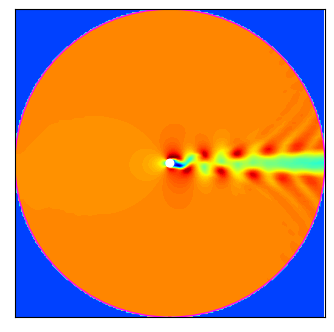

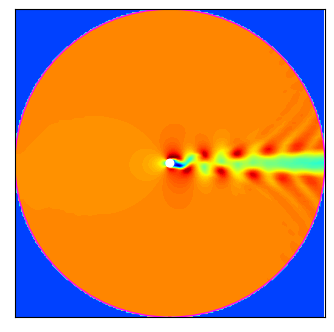

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i,snapshot_data in enumerate(snapshots.time):
  if i % 5 == 0:
    plt.gca().cla()
    cp.plot_cylinder_data(snapshot_data.xs, snapshot_data.ys, snapshot_data.us, resolution=200, ax=ax, cbar=False)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.1)

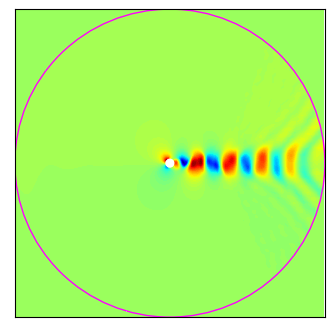

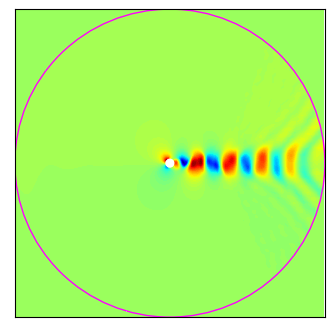

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i,snapshot_data in enumerate(snapshots.time):
  if i % 5 == 0:
    plt.gca().cla()
    cp.plot_cylinder_data(snapshot_data.xs, snapshot_data.ys, snapshot_data.vs, resolution=200, ax=ax, cbar=False)
    display.clear_output(wait=True)
    display.display(plt.gcf())

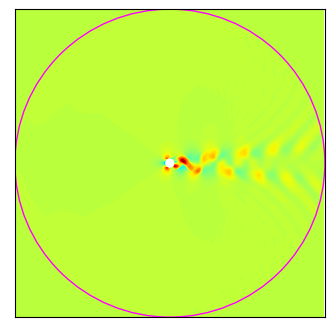

In [6]:
final_snap = snapshots.time[-1]
u_dx, v_dx = m[-1].finite_differences(final_snap.us)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cp.plot_cylinder_data(final_snap.xs, final_snap.ys, u_dx, resolution=200, ax=ax, cbar=False)

In [7]:
# weights for multiplicative scalar product
volumeWeight = mesh.volumeWeights
number_nodes = mesh.n
innerWeight = np.concatenate([np.ones(number_nodes), np.ones(number_nodes)]) * volumeWeight
# weighted scalar product
def skalar_product(q1,q2,weights=innerWeight):
    return np.sum(q1*q2*weights)

In [8]:
T = len(snapshots.time)
qs = np.array([s.q for s in snapshots.time]).reshape((T, -1))
# mean flow field
qAvg = np.mean(qs, 0)
# qAvg = qAvg.flatten()
# centered flow field
qFluc = qs - np.repeat(np.expand_dims(qAvg, 0),T,axis=0)
qFluc = qFluc.transpose()
print(qAvg.shape)
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# cp.plot_cylinder_data(final_snap.xs, final_snap.ys, qFluc[-1][0], resolution=200, ax=ax, cbar=False)

(72360,)


In [9]:
def get_POD(snapshots,skalar_product,maxPOD=8):
    ### METHOD OF SNAPSHOTS
    
    # input dimensions
    T = snapshots.shape[1]
    n = snapshots.shape[0]

    # correlation matrix
    C = np.empty((T,T))
    for i in range(T):
        # utilize symmetry of C
        for j in range(i,T):
            C[i,j] = skalar_product(snapshots[:,i], snapshots[:,j])
            C[j,i] = C[i,j] # symmetry property

    # eigenvalue problem of correlation matrix
    S, V =  np.linalg.eigh(C,UPLO='L')
    # flip due to return structure of bp.linalg.eigh
    S = np.flip(S,0) # make S in descending order
    V = np.flip(V,1) # make V correspondingly

    # construct spatial POD Modes from snapshots
    podModes = np.zeros((n,maxPOD))
    for i in range(maxPOD): # faster than straight matrix multiplication!
        podModes[:,i] = 1 / np.sqrt(S[i]) *  np.matmul(snapshots,V[:,i])

    # computing eigenvalues from snapshots
    S = np.zeros(maxPOD)
    for i in range(maxPOD):
        for j in range(T):
            S[i] += skalar_product(snapshots[:,j], podModes[:,i])**2

    return [podModes, S]

def get_activations(snapshots, podModes, skalar_product, recNum=0):
    ### COMPUTE REFERENCE ACTIVATIONS

    # input dimensions
    n = podModes.shape[1]
    T = snapshots.shape[1]

    # if reconstruction dimension is 0 -> use all possible vectors
    if recNum == 0:
        recNum = n

    # compute mode activation by projection
    activations = np.zeros((n, T))
    for t in range(T):
        for i in range(recNum):
            activations[i, t] = skalar_product(snapshots[:, t], podModes[:, i])

    return activations

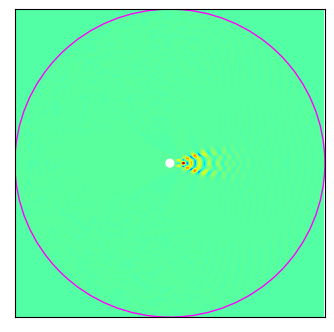

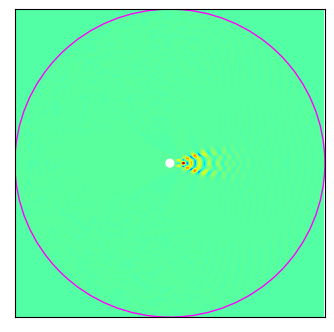

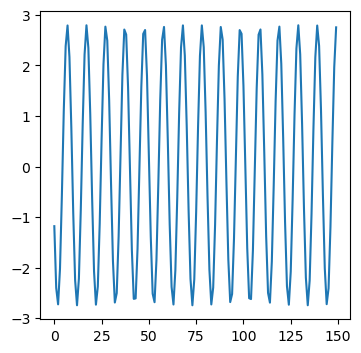

In [10]:
[podModes, S] = get_POD(qFluc,skalar_product)
activations = get_activations(qFluc, podModes, skalar_product)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i in range(podModes.shape[1]):
  plt.gca().cla()
  cp.plot_cylinder_data(final_snap.xs, final_snap.ys, podModes[:number_nodes, i], resolution=200, ax=ax, cbar=False)
  display.clear_output(wait=True)
  display.display(plt.gcf())
  time.sleep(0.1)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
x = list(range(T))
y = activations[0, :]
ax.plot(x,y)

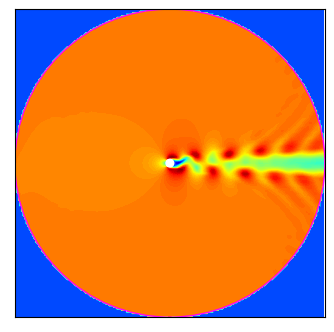

In [11]:
# reconstruction plotting 
rec = np.zeros_like(qFluc)
for j in range(6):
    rec += np.outer(podModes[:,j],activations[j,:])
rec += np.repeat(np.expand_dims(qAvg,1),T,1)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cp.plot_cylinder_data(final_snap.xs, final_snap.ys, rec[:number_nodes,0], resolution=200, ax=ax, cbar=False)

In [12]:
# convection operator
def convection(mesh, q1, q2):
    n = int(len(q1) / 2)
    # local variable vectors
    u1 = q1[:n]
    v1 = q1[n:2 * n]
    u2 = q2[:n]
    v2 = q2[n:2 * n]
    # derivatives
    [du2dx, du2dy] = mesh.finite_differences(u2)
    [dv2dx, dv2dy] = mesh.finite_differences(v2)
    # state based convection
    u_tmp = u1 * du2dx + v1 * du2dy
    v_tmp = u1 * dv2dx + v1 * dv2dy
    return -1 * np.concatenate((u_tmp, v_tmp))

# diffusion operator
def diffusion(mesh, q):
    n = int(len(q) / 2)
    # local variable vectors
    u = q[:n]
    v = q[n:2 * n]
    # derivatives
    [_, _, ulap] = mesh.finite_differences(u, computeLaplacian=True)
    [_, _, vlap] = mesh.finite_differences(v, computeLaplacian=True)
    # state based diffusion
    return np.concatenate((ulap, vlap))

In [13]:
# Galerkin system coefficients
# Computation of Galerkin system parameters
Qavg = convection(mesh,qAvg,qAvg)
Lavg = diffusion(mesh,qAvg)

num_pod_modes = 4

# initialize arrays for parameters
b1 = np.empty(num_pod_modes)
b2 = np.empty(num_pod_modes)
L1 = np.empty((num_pod_modes,num_pod_modes))
L2 = np.empty((num_pod_modes,num_pod_modes))
Q_ = [np.empty((num_pod_modes,num_pod_modes,)) for x in range(num_pod_modes)]

# compute L and Q operators for projection
Q_tmp1 = np.empty((num_pod_modes,2*number_nodes))
Q_tmp2 = np.empty((num_pod_modes,2*number_nodes))
Q_tmp3 = np.empty((num_pod_modes,num_pod_modes,2*number_nodes))
L_tmp = np.empty((num_pod_modes,2*number_nodes))

for i in tqdm(range(num_pod_modes)):
    Q_tmp1[i] = convection(mesh,qAvg,podModes[:,i])
    Q_tmp2[i] = convection(mesh,podModes[:,i],qAvg)
    L_tmp[i] = diffusion(mesh,podModes[:,i])
    for j in range(num_pod_modes):
        Q_tmp3[i,j] = convection(mesh,podModes[:,i],podModes[:,j])

# compute ODE coefficients
for k in tqdm(range(num_pod_modes)):
    b1[k] = skalar_product(Lavg,podModes[:,k],innerWeight)
    b2[k] = skalar_product(Qavg,podModes[:,k],innerWeight)
    for i in range(num_pod_modes):
        L1[k,i] = skalar_product(L_tmp[i],podModes[:,k],innerWeight)
        L2[k,i] = skalar_product(np.add(Q_tmp1[i],Q_tmp2[i]),podModes[:,k],innerWeight)
        for j in range(num_pod_modes):
            Q_[k][i,j] = skalar_product(Q_tmp3[i,j],podModes[:,k],innerWeight)

100%|██████████| 4/4 [00:00<00:00, 298.64it/s]


In [64]:
stabilization = False
nu = 0.005

# initial conditions
a0 = activations[:num_pod_modes,0]

# testing for different galerkin coefficients
phaseShift = 1.1 if stabilization else 1          # temporal shift
amplitudeShift = 1 if stabilization else 1      # artifical viscosity

# defining ode function for galerkin system
def galerkin_system(t,a):

    # set global coefficient references
    global Q_, L1, L2, b1, b2, nu
    
    # initialize state flow
    a_dot = np.empty_like(a, dtype=np.float128)

    # iterate dofs
    for k in range(a_dot.shape[0]):
        
        # compute dofs flow
        a_dot[k] = phaseShift * (amplitudeShift * nu * b1[k] + b2[k] + np.inner((amplitudeShift * nu * L1[k,:] + L2[k,:]), a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q_[k]),np.expand_dims(a,1))) 
    
    # return flow
    return a_dot

In [65]:
# defined ode solver
def solver(f,interval,y0,dt):
    
    # get initial and end time
    t = interval[0]
    tmax = interval[1]

    # compute number of steps
    Nt = np.abs(int((tmax-t)/dt)) + 1
    
    # reverse time alternative
    alt = False
    if (tmax < t):
        dt *= -1
        alt = True
    
    # initialize trajectory matrix
    y = np.zeros((y0.shape[0],Nt))

    # initial conditions
    y[:,0] = y0
    
    # RK45 predictor-corrector loop
    for i in range(Nt-1):
        k1 = dt * f(t,y[:,i])
        k2 = dt * f(t+dt/2,y[:,i] + k1/2)
        k3 = dt * f(t+dt/2,y[:,i] + k2/2)
        k4 = dt * f(t+dt,y[:,i] + k3)
        k = (k1+2*k2+2*k3+k4)/6
        y[:,i+1] = y[:,i] + k
        t = t + dt  
    
    # structured return of state trajectory
    if alt:
        return np.flip(y,1)
    else:
        return y

In [79]:
t0 = 0
tmax = 74.5
dt = 0.5
stateTrajectory = solver(galerkin_system,(t0,tmax),a0,dt)

Text(87.59722222222221, 0.5, 'a')

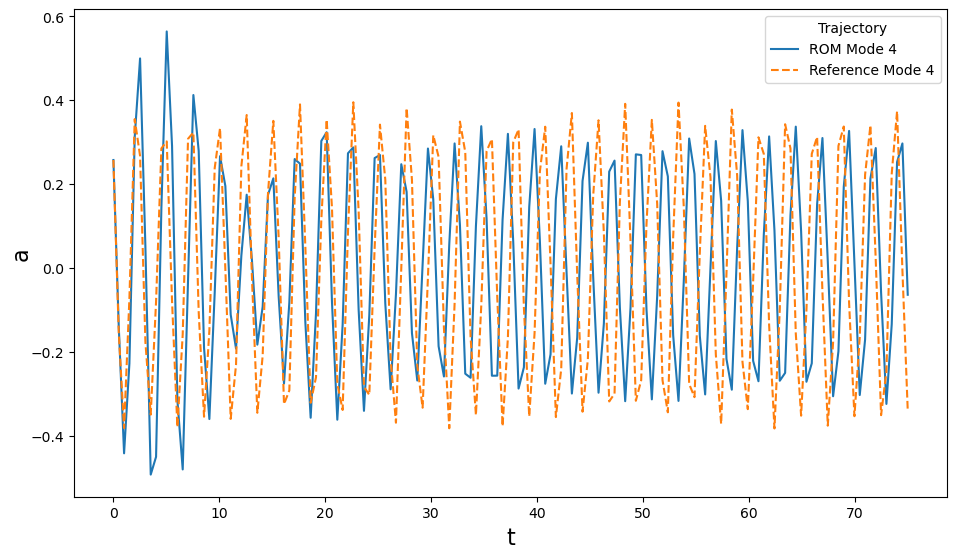

In [91]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
fig.tight_layout(pad=3.0)
# loop four dofs
for i in range(3,4):
    ax.plot(np.linspace(0,dt*len(stateTrajectory[i,:]),len(stateTrajectory[i,:]))[:],stateTrajectory[i,:],label="ROM Mode "+str(i+1))
    
for i in range(3,4):
    ax.plot(np.linspace(0,dt*len(activations[i,:]),len(activations[i,:])),activations[i,:],label="Reference Mode "+str(i+1),linestyle="dashed")

ax.legend(title="Trajectory",loc=1)
ax.set_xlabel("t",fontsize=16)
ax.set_ylabel("a",fontsize=16,labelpad=-2)

(72360, 150)


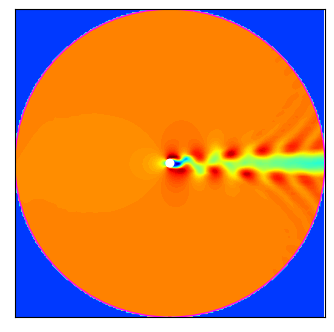

In [88]:
# reconstruction plotting 
rec = np.zeros_like(qFluc)
for j in range(4):
    rec += np.outer(podModes[:,j],stateTrajectory[j,:])
rec += np.repeat(np.expand_dims(qAvg,1),T,1)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i in range(150):
  if i % 5 == 0:
    plt.gca().cla()
    cp.plot_cylinder_data(snapshot_data.xs, snapshot_data.ys, rec[:number_nodes, i], resolution=200, ax=ax, cbar=False)
    display.clear_output(wait=True)
    display.display(plt.gcf())

# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# cp.plot_cylinder_data(final_snap.xs, final_snap.ys, rec[:number_nodes,-2], resolution=200, ax=ax, cbar=False)
